In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
path = "master_csv.csv"
df = pd.read_csv('appceleratorstudio.csv')

In [3]:
df.isnull().sum()

issuekey        0
title           0
description    43
storypoint      0
dtype: int64

In [4]:
df = df.dropna(how='any')

In [5]:
df.head()

,issuekey,title,description,storypoint
0,TISTUD-6,Add CA against object literals in function inv...,{html}<div><p>The idea here is that if our met...,1
1,TISTUD-9,Update branding for Appcelerator plugin to App...,"{html}<div><p>At least fix feature icons, asso...",1
2,TISTUD-11,Create new JSON schema for SDK team,{html}<div><p>Create JSON schema containing pr...,1
3,TISTUD-13,Create Project References Property Page,{html}<div><p>Create property page for project...,1
4,TISTUD-16,New Desktop Project Wizard,{html}<div><p>Desktop (need to convert existin...,1


In [6]:
df.storypoint.describe()

count    2876.000000
mean        5.636300
std         3.309936
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        40.000000
Name: storypoint, dtype: float64

In [7]:
import matplotlib.pyplot as plt
 
plt.hist(df.storypoint, bins=20, alpha=0.6, color='y')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
 
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
df.groupby('storypoint').size()

storypoint
1      148
2      112
3      571
5     1126
8      751
9        1
13     137
20      22
21       3
34       1
40       4
dtype: int64

### Data Preprocessing

In [9]:
df.loc[df.storypoint <= 2, 'storypoint'] = 0 #small
df.loc[(df.storypoint > 2) & (df.storypoint <= 5), 'storypoint'] = 1 #medium
df.loc[df.storypoint > 5, 'storypoint'] = 2 #big

In [10]:
df.groupby('storypoint').size()

storypoint
0     260
1    1697
2     919
dtype: int64

In [11]:
import csv
from nltk.corpus import stopwords

#Define some known html tokens that appear in the data to be removed later
htmltokens = ['{html}','<div>','<pre>','<p>', '</div>','</pre>','</p>']

#Clean operation
#Remove english stop words and html tokens

def cleanData(text):
    result = ''
    
    for w in htmltokens:
        text = text.replace(w, '')
    
    text_words = text.split()    
    
    resultwords  = [word for word in text_words if word not in stopwords.words('english')]
    
    if len(resultwords) > 0:
        result = ' '.join(resultwords)
    else:
        print('Empty transformation for: ' + text)
        
    return result

def formatFastTextClassifier(label):
    return "__label__" + str(label) + " "

In [12]:
import nltk

#nltk.download('stopwords')

df['title_desc'] = df['title'].str.lower() + ' - ' + df['description'].str.lower()
df['label_title_desc'] = df['storypoint'].apply(lambda x: formatFastTextClassifier(x)) + df['title_desc'].apply(lambda x: cleanData(str(x)))

df = df.reset_index(drop=True)

[nltk_data] Downloading package stopwords to C:\Users\Abhishek
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from collections import Counter

def SimpleOverSample(_xtrain, _ytrain):
    xtrain = list(_xtrain)
    ytrain = list(_ytrain)

    samples_counter = Counter(ytrain)
    max_samples = sorted(samples_counter.values(), reverse=True)[0]
    for sc in samples_counter:
        init_samples = samples_counter[sc]
        samples_to_add = max_samples - init_samples
        if samples_to_add > 0:
            #collect indices to oversample for the current class
            index = list()
            for i in range(len(ytrain)):
                if(ytrain[i] == sc):
                    index.append(i)
            #select samples to copy for the current class    
            copy_from = [xtrain[i] for i in index]
            index_copy = 0
            for i in range(samples_to_add):
                xtrain.append(copy_from[index_copy % len(copy_from)])
                ytrain.append(sc)
                index_copy += 1
    return xtrain, ytrain

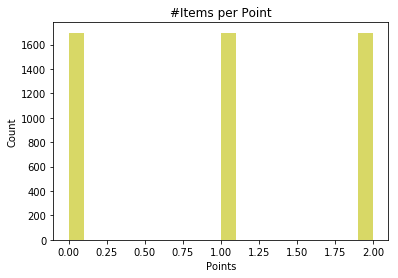

In [14]:
df_oversampled = pd.DataFrame(df, columns=['label_title_desc','storypoint'])
X_resampled, y_resampled =  SimpleOverSample(df_oversampled.label_title_desc.values.tolist(), df_oversampled.storypoint.values.tolist())

plt.hist(y_resampled, bins=20, alpha=0.6, color='y')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()

### Creating pretrained vectors

root = '../IEEE TSE2018/pretrain data/'

pretrain_files = ['apache_pretrain.csv', 
                  'jira_pretrain.csv', 
                  'spring_pretrain.csv', 
                  'talendforge_pretrain.csv', 
                  'moodle_pretrain.csv',
                  'appcelerator_pretrain.csv',
                  'duraspace_pretrain.csv',
                  'mulesoft_pretrain.csv',
                  'lsstcorp_pretrain.csv']

pretrained = None

for file in pretrain_files:
    df_pretrain = pd.read_csv(root + file, usecols=['issuekey', 'title', 'description'])
    if(pretrained is not None):
        pretrained = pd.concat([pretrained, df_pretrain])
    else:
        pretrained = df_pretrain

pretrained = pretrained.dropna(how='any')

#pretrained['title_desc'] = (pretrained['title'].str.lower() + ' - ' + pretrained['description'].str.lower()).apply(lambda x: cleanData(str(x)))
#pretrained.to_pickle('pretrained_df.pkl')
pretrained = pd.read_pickle('pretrained_df.pkl')

outfile=open("issues_pretrain.txt", mode="w", encoding="utf-8")
for line in pretrained.title_desc.values:
    outfile.write(line + '\n')
outfile.close()

#command = "fasttext skipgram -input issues_pretrain.txt -output pretrained_model -epoch 100 -wordNgrams 4 -dim 300 -minn 4 -maxn 6 -lr 0.01"
#os.system(command)

### Model Training and Results

In [15]:
import uuid

class FastTextClassifier:
    
    folderName = ""
    trainFileName = ""
    testFileName = ""
    pretrainedModelName = ""
    outputModelName = ""
    outputFileName = ""
    logFolderName = ""
    
    
    def __init__(self):
        self.rand = str(uuid.uuid4())
        self.trainFileName = "issues_train_" + self.rand + ".txt"
        self.testFileName = "issues_test_" + self.rand + ".txt"
        self.pretrainedModelName = "pretrained_model" + ".vec"
        self.outputModelName = "supervised_classifier_model_" + self.rand
        self.outputFileName = "predicted_results_" + self.rand + ".txt"
        self.logFolderName = "logfiles_" + self.rand
        
        command = "mkdir " + self.logFolderName
        os.system(command)
        
    
    def fit(self, xtrain, ytrain):
        #log folder path
        trainFilePath = self.logFolderName + "/" +self.trainFileName
        outputModelPath = self.logFolderName + "/" +self.outputModelName
        
        outfile=open(trainFilePath, mode="w", encoding="utf-8")
        for i in range(len(xtrain)):
            #line = "__label__" + str(ytrain[i]) + " " + xtrain[i]
            line = xtrain[i]
            outfile.write(line + '\n')
        outfile.close()            
        
        #fit data to model and save it
        command = "fasttext supervised -input " + trainFilePath + " -output " + outputModelPath + " -epoch 500 -wordNgrams 4 -dim 300 -minn 4 -maxn 6 -pretrainedVectors " + self.pretrainedModelName
        os.system(command)
        
        
    def predict(self, xtest):
        #log folder path
        testFilePath = self.logFolderName + "/" +self.testFileName
        outputFilePath = self.logFolderName + "/" +self.outputFileName
        outputModelPath = self.logFolderName + "/" +self.outputModelName
        
        #save test file
        outfile=open(testFilePath, mode="w", encoding="utf-8")
        for i in range(len(xtest)):
            outfile.write(xtest[i] + '\n')
        outfile.close()
        
        #get predictions     
        command =  "fasttext predict " + outputModelPath + ".bin " + testFilePath + " > " + outputFilePath
        os.system(command)
        
        outfile=open(outputFilePath, mode="r")
        test_pred = [int(line.strip('_label\r\n')) for line in outfile.readlines()]
        outfile.close()
                
        return test_pred

In [16]:
def rebuild_kfold_sets(folds, k, i):
    training_set = None
    testing_set = None

    for j in range(k):
        if(i==j):
            testing_set = folds[i]
        elif(training_set is not None):
            training_set = pd.concat([training_set, folds[j]])
        else:
            training_set = folds[j]
    
    return training_set, testing_set

In [17]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_confusion_matrix_with_accuracy(classes, y_true, y_pred, title, sum_overall_accuracy, total_predictions):
    cm = ConfusionMatrix(y_true, y_pred)
    
    print('Current Overall accuracy: ' + str(cm.stats()['overall']['Accuracy']))
    if total_predictions != 0:
        print('Total Overall Accuracy: ' + str(sum_overall_accuracy/total_predictions))
    else:
        print('Total Overall Accuracy: ' + str(cm.stats()['overall']['Accuracy']))

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(conf_matrix, classes=classes, title=title)
    plt.show()

In [18]:
import sklearn
from sklearn.metrics import confusion_matrix

from pandas_ml import ConfusionMatrix

# K-folds cross validation
# K=5 or K=10 are generally used. 
# Note that the overall execution time increases linearly with k
k = 7

# Define the classes for the classifier
classes = ['0','1','2']

# Make Dataset random before start
df_rand = df.sample(df.storypoint.count(), random_state=99)

# Make datafrane to save results
results = pd.DataFrame(columns=['True_Classes', 'Predicted_Classes'])

# Number of examples in each fold
fsamples =  int(df_rand.storypoint.count() / k)

# Fill folds (obs: last folder could contain less than fsamples datapoints)
folds = list()
for i in range(k):
    folds.append(df_rand.iloc[i * fsamples : (i + 1) * fsamples])
        
# Init
sum_overall_accuracy = 0
total_predictions = 0

# Repeat k times and average results
for i in range(k):
    
    #1 - Build new training and testing set for iteration i
    training_set, testing_set  = rebuild_kfold_sets(folds, k, i)
    y_true = testing_set.storypoint.tolist()

    #2 - Oversample (ONLY TRAINING DATA)
    X_resampled, y_resampled =  SimpleOverSample(training_set.label_title_desc.values.tolist(), training_set.storypoint.values.tolist())
    
    #3 - train
    clf = FastTextClassifier()
    clf.fit(X_resampled, y_resampled)
    
    #4 - Predict
    y_pred = clf.predict(testing_set.label_title_desc.values.tolist())
    
    #3 - Update Overall Accuracy
    for num_pred in range(len(y_pred)):
        if(y_pred[num_pred] == y_true[num_pred]):
            sum_overall_accuracy += 1
        total_predictions += 1

    #4 - Plot Confusion Matrix and accuracy 
    plot_confusion_matrix_with_accuracy(classes, y_true, y_pred, 'Confusion matrix (testing-set folder = ' + str(i) + ')', sum_overall_accuracy, total_predictions)
    
    #5 - Save true and predicted labels in results dataframe
    results = results.append(pd.concat([pd.DataFrame({'True_Classes':y_true}), pd.DataFrame({'Predicted_Classes':y_pred})], axis=1))
    
# Save the results to .pkl file
results.reset_index()
results.to_pickle('master.pkl')

AssertionError: y_true must have same size - 410 != 0

In [ ]:
y_true = results['True_Classes'].tolist()
y_pred = results['Predicted_Classes'].tolist()

In [ ]:
from statsmodels.graphics import mosaicplot

mosaicplot.mosaic(data=results, index=['True_Classes','Predicted_Classes'], title='Mosaic Plot')
plt.show()

In [ ]:
cm = ConfusionMatrix(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes, title='Confusion Matrix (Overall)')
plt.show()

print('Cohen\'s Kappa value: ', cm.stats()['overall']['Kappa'])

In [ ]:
cm.stats()['class']

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

scores = precision_recall_fscore_support(y_true, y_pred)
print('Scores:')
print('Precision for classes {}: {}'.format(classes,scores[0]))
print('Recall for classes {}: {}'.format(classes,scores[1]))
print('F-Score for classes {}: {}'.format(classes,scores[2]))
print('Prediction count for classes {}: {}'.format(classes,scores[3]))

End of Notebook